# Мастерская 2. Маркетинг

## Введение

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

Цель - предсказать вероятность покупки в течение 90 дней.

## Описание данных

Файл apparel-purchases.csv.

История покупок.

client_id - идентификатор пользователя.  
quantity - количество товаров в заказе.  
price - цена товара.  
category_ids - вложенные категории, к которым отнсится товар.  
date - дата покупки.  
message_id - идентификатор сообщения из рассылки.  


Файл apparel-messages.csv.  

История рекламных рассылок.  

bulk_campaign_id - идентификатор рекламной кампании.  
client_id - идентификатор пользователя.  
message_id - идентификатор сообщений.  
event - тип действия.  
channel - канал рассылки.  
date - дата рассылки.  
created_at - точное время создания сообщения.  


Файл apparel-target_binary.csv.

Cовершит ли клиент покупку в течение следующих 90 дней.  

client_id - идентификатор пользователя.
target целевой признак.


In [2]:
!pip install -U scikit-learn
!pip install phik -q 
!pip install optuna
!pip install optuna.integration
!pip install shap

     |████████████████████████████████| 13.4 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 83.2 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
     |████████████████████████████████| 362 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 1.3 MB/s eta 0:00:011
     |████████████████████████████████| 539 kB 1.1 MB/s eta 0:00:01


In [3]:
import pandas as pd
import numpy as np
import math 
import phik
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from time import time
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import datetime
from optuna import distributions
from lightgbm import LGBMRegressor, LGBMClassifier
from optuna.integration import OptunaSearchCV
import shap
from shap import Explanation, KernelExplainer
from shap.plots import waterfall, beeswarm
import warnings
warnings.filterwarnings('ignore')

## Загрузка данных

In [4]:
#ф-ция для вывода осн.инф-ции по датасетам
def dataset_describe(dataset, head=5):
    dataset.info()
    display(dataset.head(head))

Рекламные рассылки.

In [5]:
messages = pd.read_csv('apparel-messages.csv', parse_dates=['date','created_at'])

In [6]:
dataset_describe(messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


Покупки.

In [7]:
purchases = pd.read_csv('apparel-purchases.csv', parse_dates=['date'])

In [8]:
dataset_describe(purchases)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


Совершит ли клиент покупку в течение 90 дней.

In [9]:
target = pd.read_csv('apparel-target_binary.csv')

In [10]:
dataset_describe(target)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


Файлы загружены в три датафрейма.  
В датафрейме target 49849 записей.  Все столбцы заполнены, пропусков нет.  
В датафрейме purchases 202208 записей, пропусков также нет, типы данных столбцов вопросов не вызывают.  
Датафрейм messages очень большой, на 12 млн. записей. Типы данных столбцов также вопросов не вызывают. По количеству пропусков информацию не получили, но нам не вся информация из этого датафрейма и понадобится.


## Предобработка данных

Найдем явные задвоения в каждом датафрейме, если такие имеются.

In [11]:
target.duplicated().sum()

0

In [12]:
purchases.duplicated().sum()

73020

In [13]:
messages.duplicated().sum()

48610

Задвоения есть в purchases и messages. Удалим их.

In [14]:
purchases = purchases.drop_duplicates()

In [15]:
messages = messages.drop_duplicates()

Проверим датасеты после удаления.

In [16]:
len(purchases)

129188

In [17]:
len(messages)

12691188

Удаления прошли успешно.

Проверим, содержат ли датафреймы пустые значения.

In [18]:
target.isna().sum()

client_id    0
target       0
dtype: int64

In [19]:
purchases.isna().sum()

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

In [20]:
messages.isna().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

Пустых значений нигде нет.

Теперь рассмотрим количественные и категориальные значения во всех датафреймах.

Датафрейм messages.

Столбцы с id можно было бы проверить на уникальность, но поскольку по смыслу id могут повторяться, то проверим просто на всякий случай.

In [21]:
messages['bulk_campaign_id'].describe()

count    1.269119e+07
mean     1.159768e+04
std      3.262181e+03
min      5.480000e+02
25%      8.746000e+03
50%      1.351600e+04
75%      1.415800e+04
max      1.465700e+04
Name: bulk_campaign_id, dtype: float64

In [22]:
messages['client_id'].describe()

count    1.269119e+07
mean     1.515916e+18
std      1.329008e+08
min      1.515916e+18
25%      1.515916e+18
50%      1.515916e+18
75%      1.515916e+18
max      1.515916e+18
Name: client_id, dtype: float64

In [23]:
messages['message_id'].describe()

count                                   12691188
unique                                   9061667
top       1515915625489095763-6251-6311b13a4cf78
freq                                        1427
Name: message_id, dtype: object

Ничего интересного в столбцах с id.

In [24]:
messages['event'].sort_values().unique()

array(['click', 'close', 'complain', 'hard_bounce', 'hbq_spam', 'open',
       'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe'],
      dtype=object)

Обнаружены разные события, менять что-то причин не вижу.

In [25]:
messages['channel'].sort_values().unique()

array(['email', 'mobile_push'], dtype=object)

Всего два, явно разных канала.

In [26]:
messages['date'].describe(datetime_is_numeric=True)

count                         12691188
mean     2023-06-04 17:27:00.569989632
min                2022-05-19 00:00:00
25%                2022-12-16 00:00:00
50%                2023-07-20 00:00:00
75%                2023-11-21 00:00:00
max                2024-02-15 00:00:00
Name: date, dtype: object

Видим даты за срок чуть меньше двух лет.

In [27]:
messages['created_at'].describe(datetime_is_numeric=True)

count                         12691188
mean     2023-06-05 04:38:55.658559232
min                2022-05-19 00:14:20
25%                2022-12-16 19:15:55
50%                2023-07-20 11:09:42
75%                2023-11-21 15:58:05
max                2024-02-15 23:58:40
Name: created_at, dtype: object

С точки зрения точного времени примерно такой же диапазон.

Датафрейм purchases.

In [28]:
purchases['client_id'].describe()

count    1.291880e+05
mean     1.515916e+18
std      1.452553e+08
min      1.515916e+18
25%      1.515916e+18
50%      1.515916e+18
75%      1.515916e+18
max      1.515916e+18
Name: client_id, dtype: float64

In [29]:
purchases['message_id'].describe()

count                                     129188
unique                                     50204
top       1515915625489095763-6251-6311b13a4cf78
freq                                         222
Name: message_id, dtype: object

В этих двух столбцах с id тоже ничего интересного.

In [30]:
purchases['category_ids'].describe()

count                       129188
unique                         933
top       ['4', '28', '57', '431']
freq                          6191
Name: category_ids, dtype: object

Здесь какие-то категории товара, подробной информации про них нет, заданные числами, объединенными в строку. Попробуем достать все эти категории в явном виде.

In [31]:
category_series = purchases['category_ids']
category_series

0           ['4', '28', '57', '431']
1           ['4', '28', '57', '431']
2           ['4', '28', '57', '431']
3          ['4', '28', '244', '432']
4           ['4', '28', '49', '413']
                     ...            
202196    ['4', '28', '260', '1194']
202198     ['2', '18', '212', '726']
202204     ['4', '27', '233', '462']
202206     ['2', '18', '274', '446']
202207      ['4', '28', '62', '656']
Name: category_ids, Length: 129188, dtype: object

In [32]:
category_series = category_series.str.replace(']','').str.replace('[','').str.replace("'",'').str.replace(' ','').str.split(',')

In [33]:
category_series

0           [4, 28, 57, 431]
1           [4, 28, 57, 431]
2           [4, 28, 57, 431]
3          [4, 28, 244, 432]
4           [4, 28, 49, 413]
                 ...        
202196    [4, 28, 260, 1194]
202198     [2, 18, 212, 726]
202204     [4, 27, 233, 462]
202206     [2, 18, 274, 446]
202207      [4, 28, 62, 656]
Name: category_ids, Length: 129188, dtype: object

In [34]:
category_series.str.len().value_counts()

4    124747
1      3360
3       736
5       345
Name: category_ids, dtype: int64

Не более 5 категорий. Добавим их в виде отдельных столбцов в purchases.

In [35]:
def category_group(category,num):
    cat_list = category.replace(']','').replace('[','').replace("'",'').replace(' ','').split(',')
    if len(cat_list) > num:
        if cat_list[num] == '' or cat_list[num] == 'None':
            return 0
        else:
            return int(cat_list[num])
    else:
        return 0

Посколько какие-то категории были пустые, а в каких-то был 'None', в функции сразу пропишем соответствующие замены.

In [36]:
for i in range(0, 5):
    purchases['cat_' + str(i)] = purchases['category_ids'].apply(category_group, num=i)

Посмотрим, что получилось.

In [37]:
dataset_describe(purchases)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129188 entries, 0 to 202207
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     129188 non-null  int64         
 1   quantity      129188 non-null  int64         
 2   price         129188 non-null  float64       
 3   category_ids  129188 non-null  object        
 4   date          129188 non-null  datetime64[ns]
 5   message_id    129188 non-null  object        
 6   cat_0         129188 non-null  int64         
 7   cat_1         129188 non-null  int64         
 8   cat_2         129188 non-null  int64         
 9   cat_3         129188 non-null  int64         
 10  cat_4         129188 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(2)
memory usage: 11.8+ MB


,client_id,quantity,price,category_ids,date,message_id,cat_0,cat_1,cat_2,cat_3,cat_4
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,0
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,4,28,57,431,0
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,57,431,0
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,244,432,0
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,4,28,49,413,0


Во всех добавленных столбцах - числа, как и задумывалось.

Посмотрим на каждый столбец отдельно на всякий случай, через список уникальных значений, если значений немного и через describe, если много.

In [38]:
purchases['cat_0'].sort_values().unique()

array([   0,    1,    2,    3,    4,    5, 5562, 5963, 6060])

In [39]:
purchases['cat_1'].sort_values().unique()

array([   0,    8,   10,   12,   14,   17,   18,   22,   27,   28,   29,
         30,   31,   44, 1822, 5536, 5558, 5589, 5597, 5599, 5630, 5631,
       5632, 5633, 5634, 5683, 5697, 5837, 5959, 6057, 6058, 6059])

In [40]:
#purchases['cat_2'].sort_values().unique()
purchases['cat_2'].describe()

count    129188.000000
mean       1737.924993
std        2446.268124
min           0.000000
25%         171.000000
50%         274.000000
75%        5549.000000
max        6309.000000
Name: cat_2, dtype: float64

In [41]:
#purchases['cat_3'].sort_values().unique()
purchases['cat_3'].describe()

count    129188.000000
mean        875.127427
std        1041.499742
min           0.000000
25%         432.000000
50%         551.000000
75%         726.000000
max        6323.000000
Name: cat_3, dtype: float64

In [42]:
purchases['cat_4'].sort_values().unique()

array([  0, 467])

Выяснили, что категории товара кодируются числами от единиц до шести тычяч.

In [43]:
purchases['quantity'].describe()

count    129188.000000
mean          1.009420
std           0.220332
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: quantity, dtype: float64

Количество продаж за один раз от 1 до 30 шт.

In [44]:
purchases['price'].describe()

count    129188.000000
mean       1264.532766
std        1375.016339
min           1.000000
25%         399.000000
50%         999.000000
75%        1750.000000
max       85499.000000
Name: price, dtype: float64

Цены от 1 рубля до 85 тысяч. Ни то, ни другое явной ошибкой точно не выглядит.

In [45]:
purchases['date'].describe(datetime_is_numeric=True)

count                           129188
mean     2023-02-26 07:40:09.771805440
min                2022-05-16 00:00:00
25%                2022-09-09 00:00:00
50%                2023-03-22 00:00:00
75%                2023-06-28 00:00:00
max                2024-02-16 00:00:00
Name: date, dtype: object

Разброс дат почти такой же как и в messages.

Датафрейм target.

Проверим client_id на уникальность.

In [46]:
target['client_id'].duplicated().sum()

0

Проверим target.

In [47]:
target['target'].sort_values().unique()

array([0, 1])

Только нули и единицы, как и должно быть.

На этапе предобработки данных удалены задвоения, исходные данные проверены с точки зрения пропусков. Категории проданного товара выделены в отдельные столбцы вместо перечисления в одной строке.

## Исследовательский анализ данных

Рассмотрим датафрейм purchases.

count    129188.000000
mean          1.009420
std           0.220332
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: quantity, dtype: float64


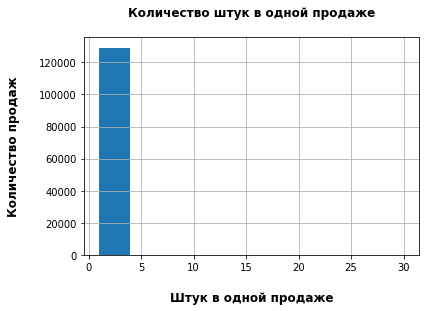

In [48]:
print(purchases['quantity'].describe())
purchases['quantity'].hist(bins=10)
plt.title("Количество штук в одной продаже\n", fontsize=12, fontweight="bold")
plt.xlabel("\nШтук в одной продаже", fontsize=12, fontweight="bold")
plt.ylabel("Количество продаж\n",  fontsize=12, fontweight="bold")
plt.show()

In [49]:
purchases['quantity'].value_counts()

1     128352
2        714
3         86
4         12
6          4
5          3
10         3
15         3
20         2
25         2
30         2
7          1
8          1
9          1
13         1
18         1
Name: quantity, dtype: int64

Почти в любой продаже по одной штуке.

count                           129188
mean     2023-02-26 07:40:09.771805440
min                2022-05-16 00:00:00
25%                2022-09-09 00:00:00
50%                2023-03-22 00:00:00
75%                2023-06-28 00:00:00
max                2024-02-16 00:00:00
Name: date, dtype: object


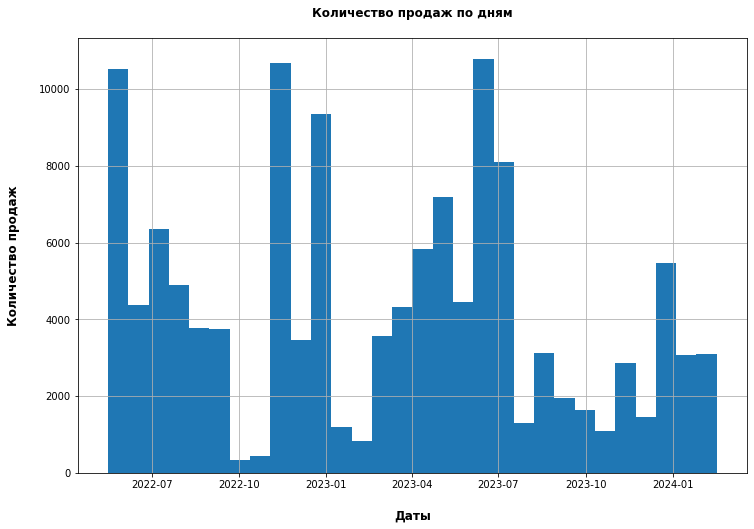

In [50]:
print(purchases['date'].describe(datetime_is_numeric=True))
purchases['date'].hist(bins=30,figsize=[12, 8])
plt.title("Количество продаж по дням\n", fontsize=12, fontweight="bold")
plt.xlabel("\nДаты", fontsize=12, fontweight="bold")
plt.ylabel("Количество продаж\n",  fontsize=12, fontweight="bold")
plt.show()

Продажи осуществлялись с мая 2022 года по февраль 2024.  
Можно сказать, что бóльшая часть продаж приходится на летние месяцы или на новый год.

count    129188.000000
mean       1264.532766
std        1375.016339
min           1.000000
25%         399.000000
50%         999.000000
75%        1750.000000
max       85499.000000
Name: price, dtype: float64


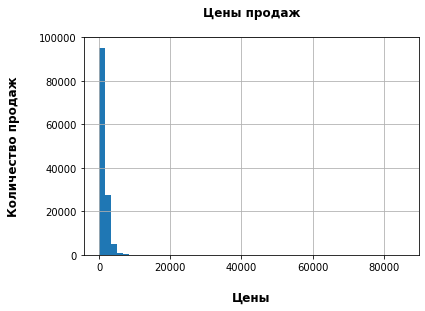

In [51]:
print(purchases['price'].describe())
purchases['price'].hist(bins=50)
plt.title("Цены продаж\n", fontsize=12, fontweight="bold")
plt.xlabel("\nЦены", fontsize=12, fontweight="bold")
plt.ylabel("Количество продаж\n",  fontsize=12, fontweight="bold")
plt.show()

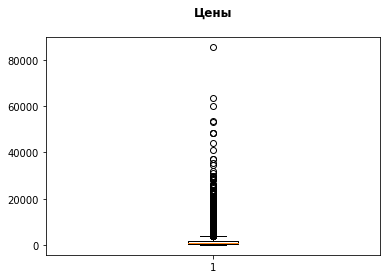

In [52]:
plt.boxplot(purchases['price'])
plt.title("Цены\n", fontsize=12, fontweight="bold")
plt.show()

Цены свыше 40000 выглядят как явные выбросы, но с учётом того, что по условию задачи возможны и такие цены, не меняю это.

Остальные столбцы в purchases смысла рассматривать не вижу.  
Рассмотрим только ещё, что получилось в первом добавленном столбце категорий - cat_0. В остальных категориях слишком много разных вариантов, это было видно на предыдущем этапе.

In [53]:
purchases['cat_0'].value_counts()

4       73428
5562    29148
2       17995
6060     4458
0        3360
5963      789
3           6
1           3
5           1
Name: cat_0, dtype: int64

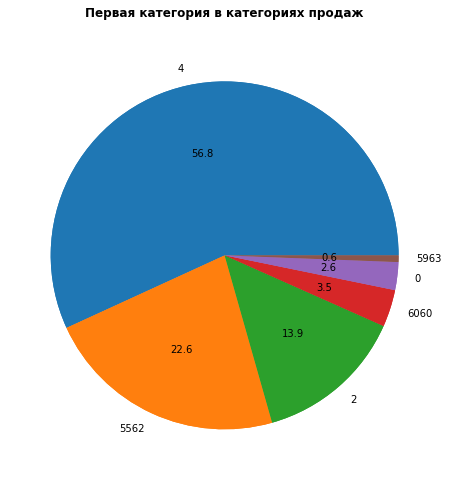

In [54]:
purchases['cat_0'].value_counts()[purchases['cat_0'].value_counts()>700].plot(kind='pie', figsize=[15, 8])
plt.title("Первая категория в категориях продаж\n", fontsize=12, fontweight="bold")
plt.pie(purchases['cat_0'].value_counts()[purchases['cat_0'].value_counts()>700].values, autopct='%.1f')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

Бóльшая часть продаж относится к категории 4, также много категорий 5562 и 2.

Рассмотрим датафрейм messages.

In [55]:
messages['event'].value_counts()

send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: event, dtype: int64

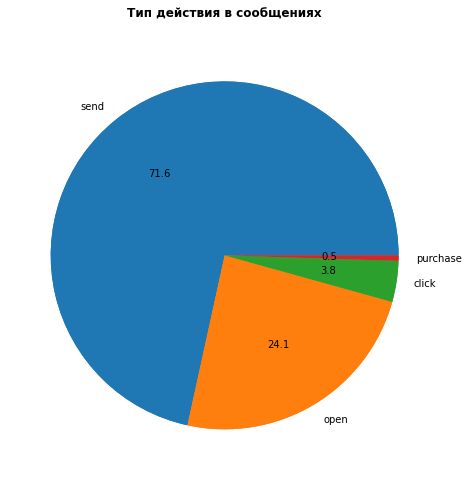

In [56]:
messages['event'].value_counts()[messages['event'].value_counts()>50000].plot(kind='pie', figsize=[15, 8])
plt.title("Тип действия в сообщениях\n", fontsize=12, fontweight="bold")
plt.pie(messages['event'].value_counts()[messages['event'].value_counts()>50000].values, autopct='%.1f')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

Подавляющее большинство действий это отправка и открытие сообщений. Покупок очень мало среди всех событий.

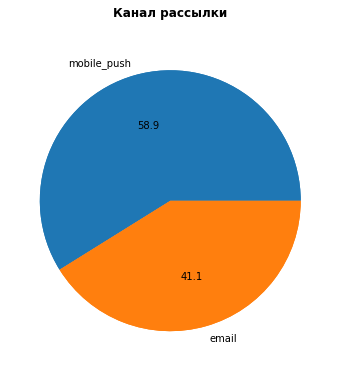

In [57]:
messages['channel'].value_counts()[messages['channel'].value_counts()>50000].plot(kind='pie', figsize=[10, 6])
plt.title("Канал рассылки\n", fontsize=12, fontweight="bold")
plt.pie(messages['channel'].value_counts()[messages['channel'].value_counts()>50000].values, autopct='%.1f')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

С точки зрения канала рассылки большая часть у мобильных уведомлений, меньшая часть у электронной почты.

count                         12691188
mean     2023-06-04 17:27:00.569989632
min                2022-05-19 00:00:00
25%                2022-12-16 00:00:00
50%                2023-07-20 00:00:00
75%                2023-11-21 00:00:00
max                2024-02-15 00:00:00
Name: date, dtype: object


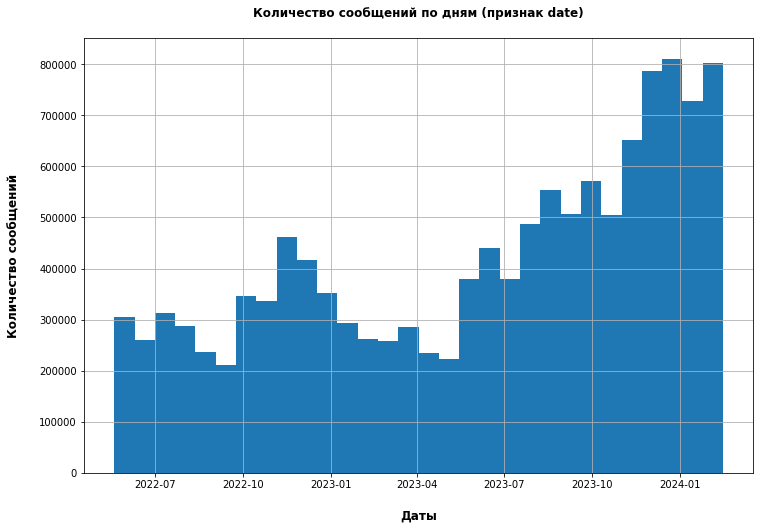

In [58]:
print(messages['date'].describe(datetime_is_numeric=True))
messages['date'].hist(bins=30,figsize=[12, 8])
plt.title("Количество сообщений по дням (признак date)\n", fontsize=12, fontweight="bold")
plt.xlabel("\nДаты", fontsize=12, fontweight="bold")
plt.ylabel("Количество сообщений\n",  fontsize=12, fontweight="bold")
plt.show()

count                         12691188
mean     2023-06-05 04:38:55.658559232
min                2022-05-19 00:14:20
25%                2022-12-16 19:15:55
50%                2023-07-20 11:09:42
75%                2023-11-21 15:58:05
max                2024-02-15 23:58:40
Name: created_at, dtype: object


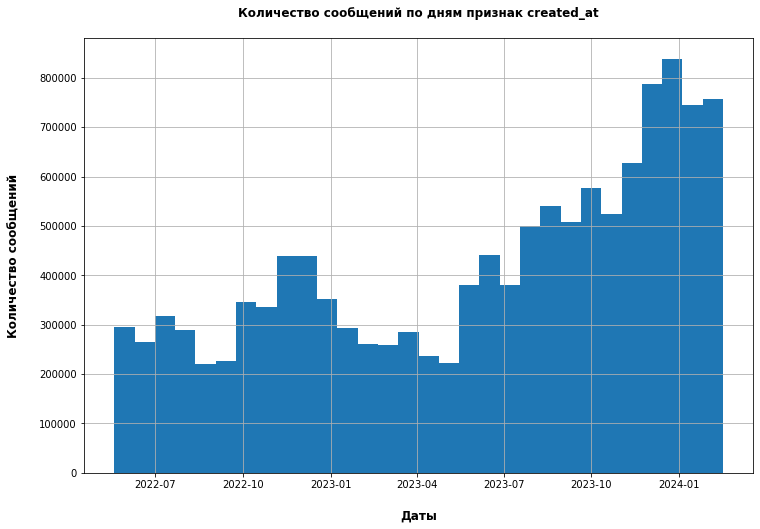

In [59]:
print(messages['created_at'].describe(datetime_is_numeric=True))
messages['created_at'].hist(bins=30,figsize=[12, 8])
plt.title("Количество сообщений по дням признак created_at\n", fontsize=12, fontweight="bold")
plt.xlabel("\nДаты", fontsize=12, fontweight="bold")
plt.ylabel("Количество сообщений\n",  fontsize=12, fontweight="bold")
plt.show()

Убедились, что  date и created_at одно и то же, графики очень похожи.  
Кроме этого можно сказать, что количество сообщений в течении двух лет выросло, чего нельзя сказать о количестве продаж.  

Можно сделать следующие выводы по этому этапу:
- за одну продажу продается как правило одна штука какого-либо товара,
- продажи осуществлялись с мая 2022 года по февраль 2024,
- за этот же период была рассылка сообщений,
- бóльшая часть продаж приходится на летние месяцы или на новый год,
- цены от 1 рубля до 40 тысяч рублей,
- большинство действий это отправка и открытие сообщений,
- с точки зрения канала рассылки бóльшая часть у мобильных уведомлений, меньшая часть у электронной почты,
- количество рассылаемых сообщений в течении двух лет выросло, а продажи - нет.


## Добавление признаков.

Можно предположить, что первая категория является самой важной. Далее будет использовать её.  
Создадим сводную по этому признаку.

In [60]:
first_cat = purchases.pivot_table(index='client_id',columns=['cat_0'], values='quantity', aggfunc='sum', fill_value=0).reset_index()

In [61]:
first_cat.head()

cat_0,client_id,0,1,2,3,4,5,5562,5963,6060
0,1515915625468060902,0,0,0,0,5,0,0,0,0
1,1515915625468061003,0,0,0,0,6,0,0,0,0
2,1515915625468061099,0,0,0,0,1,0,0,0,0
3,1515915625468061100,0,0,0,0,1,0,0,0,0
4,1515915625468061170,1,0,1,0,6,0,0,0,0


Далее определим разницу с датой последней продажи.

In [62]:
last_purchase = purchases.pivot_table(index='client_id', values='date', aggfunc='max', fill_value=0).reset_index()

In [63]:
last_purchase.head()

,client_id,date
0,1515915625468060902,2022-05-27
1,1515915625468061003,2023-01-04
2,1515915625468061099,2022-05-17
3,1515915625468061100,2024-02-10
4,1515915625468061170,2023-06-17


В качестве максимальной даты берём 16.02.24, как максимальную дату из имеющихся.

In [64]:
last_purchase['max_date'] = datetime.date(2024, 2, 16)

In [65]:
last_purchase['max_date'] = pd.to_datetime(last_purchase['max_date'])

In [66]:
last_purchase['diff_days'] = (last_purchase['max_date'] - last_purchase['date'] ) / np.timedelta64 ( 1 , 'D')

In [67]:
last_purchase = last_purchase.drop('date',axis=1)
last_purchase = last_purchase.drop('max_date',axis=1)

In [68]:
last_purchase.head()

,client_id,diff_days
0,1515915625468060902,630.0
1,1515915625468061003,408.0
2,1515915625468061099,640.0
3,1515915625468061100,6.0
4,1515915625468061170,244.0


События тоже соберём в сводную таблицу.

In [69]:
events = messages.pivot_table(index='client_id', columns=['event'], values='date', aggfunc='count', fill_value=0).reset_index()

In [70]:
events.head()

event,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
0,1515915625468060902,10,0,0,0,0,35,5,126,0,0,1
1,1515915625468061003,5,0,0,0,0,5,1,154,0,0,0
2,1515915625468061099,8,0,0,2,0,51,0,215,0,0,0
3,1515915625468061100,1,0,0,1,0,157,1,267,1,0,0
4,1515915625468061170,16,0,0,0,0,31,3,243,0,0,0


То же самое с каналами.

In [71]:
channels = messages.pivot_table(index='client_id', columns=['channel'], values='date', aggfunc='count', fill_value=0).reset_index()

In [72]:
channels.head()

channel,client_id,email,mobile_push
0,1515915625468060902,177,0
1,1515915625468061003,165,0
2,1515915625468061099,182,94
3,1515915625468061100,0,428
4,1515915625468061170,202,91


Добавим количество продаж.

In [73]:
purchases_count = purchases.pivot_table(index='client_id', values='quantity', aggfunc='count', fill_value=0).reset_index()

In [74]:
purchases_count.head()

,client_id,quantity
0,1515915625468060902,5
1,1515915625468061003,6
2,1515915625468061099,1
3,1515915625468061100,1
4,1515915625468061170,8


Также добавим сумму проданных штук.

In [75]:
purchases_sum = purchases.pivot_table(index='client_id', values='quantity', aggfunc='count', fill_value=0).reset_index()

In [76]:
purchases_sum.columns = ['client_id', 'sum_qty']

In [77]:
purchases_sum.head()

,client_id,sum_qty
0,1515915625468060902,5
1,1515915625468061003,6
2,1515915625468061099,1
3,1515915625468061100,1
4,1515915625468061170,8


Найдем среднюю цену на клиента.

In [78]:
price_mean = purchases.pivot_table(index='client_id', values='price', aggfunc='mean', fill_value=0).reset_index()

In [79]:
price_mean.head()

,client_id,price
0,1515915625468060902,959.000000
1,1515915625468061003,2355.833333
2,1515915625468061099,299.000000
3,1515915625468061100,1049.000000
4,1515915625468061170,1762.750000


Отдельно выделим продажи за последние 90 дней. 90 дней будем считать от максимальной даты, поэтому выбираем продажи, начиная с 18.11.2023.

In [80]:
purchases_in_90 = purchases[purchases['date']>='2023-11-18'].pivot_table(index='client_id', values='quantity', aggfunc='count', fill_value=0).reset_index()

In [81]:
purchases_in_90.columns = ['client_id', 'qty_in_90']

In [82]:
purchases_in_90.head()

,client_id,qty_in_90
0,1515915625468061100,1
1,1515915625468062558,2
2,1515915625468063026,1
3,1515915625468065652,3
4,1515915625468069873,2


Также выделим продажи вне последих 90 дней.

In [83]:
purchases_before_90 = purchases[purchases['date']<'2023-11-18'].pivot_table(index='client_id', values='quantity', aggfunc='count', fill_value=0).reset_index()

In [84]:
purchases_before_90.columns = ['client_id', 'qty_before_90']

In [85]:
purchases_before_90.head()

,client_id,qty_before_90
0,1515915625468060902,5
1,1515915625468061003,6
2,1515915625468061099,1
3,1515915625468061170,8
4,1515915625468061514,1


Объединим target и всё вышеперечисленное в датасет main.

In [86]:
main = target.merge(first_cat, on='client_id', how='left')

In [87]:
main.head()

,client_id,target,0,1,2,3,4,5,5562,5963,6060
0,1515915625468060902,0,0,0,0,0,5,0,0,0,0
1,1515915625468061003,1,0,0,0,0,6,0,0,0,0
2,1515915625468061099,0,0,0,0,0,1,0,0,0,0
3,1515915625468061100,0,0,0,0,0,1,0,0,0,0
4,1515915625468061170,0,1,0,1,0,6,0,0,0,0


In [88]:
main = main.merge(last_purchase, on='client_id', how='left')

In [89]:
main = main.merge(purchases_count, on='client_id', how='left')

In [90]:
main = main.merge(purchases_sum, on='client_id', how='left')

In [91]:
main = main.merge(price_mean, on='client_id', how='left')

In [92]:
main = main.merge(events, on='client_id', how='left')

In [93]:
main = main.merge(channels, on='client_id', how='left')

In [94]:
main = main.merge(purchases_in_90, on='client_id', how='left')

In [95]:
main = main.merge(purchases_before_90, on='client_id', how='left')

In [96]:
dataset_describe(main)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 0 to 49848
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   client_id      49849 non-null  int64  
 1   target         49849 non-null  int64  
 2   0              49849 non-null  int64  
 3   1              49849 non-null  int64  
 4   2              49849 non-null  int64  
 5   3              49849 non-null  int64  
 6   4              49849 non-null  int64  
 7   5              49849 non-null  int64  
 8   5562           49849 non-null  int64  
 9   5963           49849 non-null  int64  
 10  6060           49849 non-null  int64  
 11  diff_days      49849 non-null  float64
 12  quantity       49849 non-null  int64  
 13  sum_qty        49849 non-null  int64  
 14  price          49849 non-null  float64
 15  click          41982 non-null  float64
 16  close          41982 non-null  float64
 17  complain       41982 non-null  float64
 18  hard_b

,client_id,target,0,1,2,3,4,5,5562,5963,...,open,purchase,send,soft_bounce,subscribe,unsubscribe,email,mobile_push,qty_in_90,qty_before_90
0,1515915625468060902,0,0,0,0,0,5,0,0,0,...,35.0,5.0,126.0,0.0,0.0,1.0,177.0,0.0,NaN,5.0
1,1515915625468061003,1,0,0,0,0,6,0,0,0,...,5.0,1.0,154.0,0.0,0.0,0.0,165.0,0.0,NaN,6.0
2,1515915625468061099,0,0,0,0,0,1,0,0,0,...,51.0,0.0,215.0,0.0,0.0,0.0,182.0,94.0,NaN,1.0
3,1515915625468061100,0,0,0,0,0,1,0,0,0,...,157.0,1.0,267.0,1.0,0.0,0.0,0.0,428.0,1.0,NaN
4,1515915625468061170,0,1,0,1,0,6,0,0,0,...,31.0,3.0,243.0,0.0,0.0,0.0,202.0,91.0,NaN,8.0


In [97]:
main = main.fillna(0)

In [98]:
interval_cols =['client_id', 'target', 0, 1, 2, 3, 4, 5, 5562, 5963, 6060, 'quantity', 'diff_days', 'sum_qty', 'price', 'click', 'close', 'complain', 'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe', 'email', 'mobile_push', 'qty_in_90', 'qty_before_90']

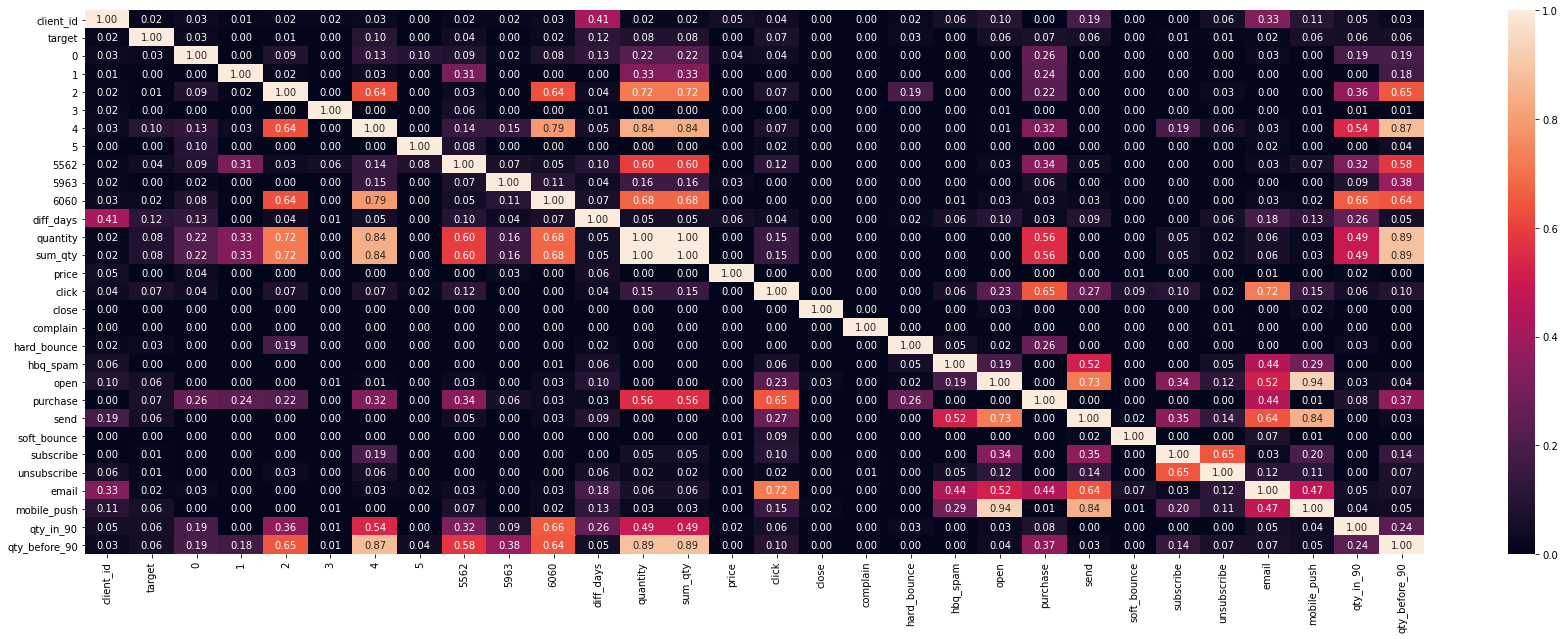

In [99]:
ig, ax = plt.subplots(figsize=(30, 10))
sns.heatmap(main.phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f') 
display()

Убираем open и sum_qty из-за мультиколлинеарности (значения больше 0,9).

In [100]:
main = main.drop('open',axis=1)

In [101]:
main = main.drop('sum_qty',axis=1)

In [102]:
interval_cols =['client_id', 'target', 0, 1, 2, 3, 4, 5, 5562, 5963, 6060, 'quantity', 'diff_days', 'price', 'click', 'close', 'complain', 'hard_bounce', 'hbq_spam', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe', 'email', 'mobile_push', 'qty_in_90', 'qty_before_90']

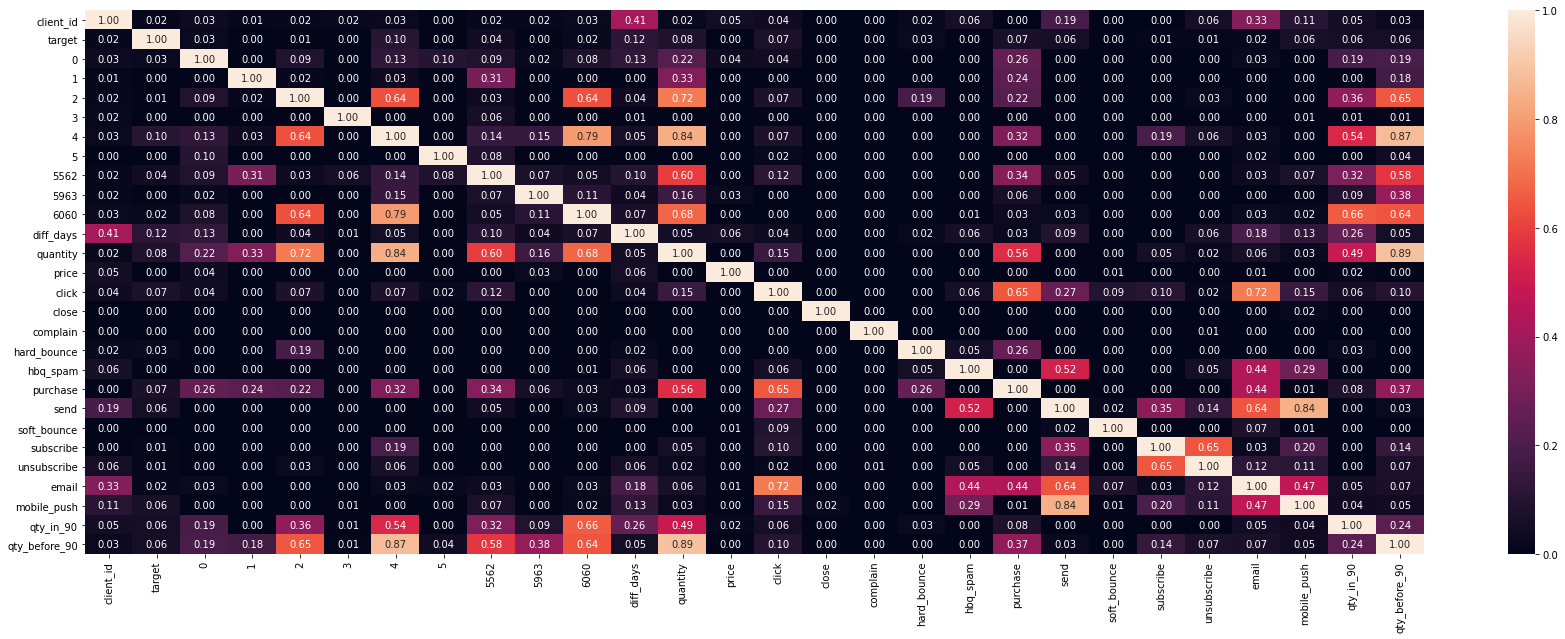

In [103]:
ig, ax = plt.subplots(figsize=(30, 10))
sns.heatmap(main.phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f') 
display()

Мультиколлинеарности больше нет, этот датафрейм буду использовать для обучения моделей.

На этом этапе данные сведены в один датафрейм main, а также добавлены признаки для обучения моделей.

## Обучение моделей

Предварительно приведем все название столбов к текстовому формату.

In [104]:
main.columns = main.columns.astype(str) 

Обучим две модели, линейная регрессия и LightGBM.

In [105]:
RANDOM_STATE = 42

X = main.drop(columns='target')
y = main['target']
X_train, X_test, y_train, y_test = train_test_split(
X,
y,
random_state=RANDOM_STATE, stratify=y
)


### Линейная регрессия.

In [106]:
num_col_names = ['client_id', '0', '1', '2', '3', '4', '5', '5562', 
                 '5963', '6060', 'quantity', 'diff_days','price', 'click', 'close', 
                 'complain', 'hard_bounce', 'hbq_spam',  'purchase', 'send', 'soft_bounce', 
                 'subscribe', 'unsubscribe', 'email', 'mobile_push','qty_in_90','qty_before_90']

scaler = StandardScaler()

In [107]:
X_train_scaled = scaler.fit_transform(X_train[num_col_names]) 

In [108]:
X_test_scaled = scaler.transform(X_test[num_col_names]) 

In [109]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

In [110]:
X_train_df = X_train_scaled.copy()

In [111]:
X_test_df = X_test_scaled.copy()

In [112]:
clf = LogisticRegression()

In [113]:
start_time_lr = time()
result_lr = cross_val_score(clf, X_train_df, y_train,  scoring='roc_auc', cv=20) 
end_time_lr = time()

In [114]:
time_lr_train = end_time_lr - start_time_lr
print(f'Время обучения линейной регресии: {time_lr_train:.2f} секунд')

Время обучения линейной регресии: 14.28 секунд


In [115]:
print(f'RMSE линейной регрессии на кросс-валидации равен {result_lr.mean():.3f}')

RMSE линейной регрессии на кросс-валидации равен 0.722


### Модель LightGBM.

In [116]:
X_train_light = X_train.copy() 

In [117]:
X_test_light = X_test.copy() 

In [118]:
parameters_light =  {
    'num_leaves': distributions.IntDistribution(2, 128),
    'learning_rate': distributions.FloatDistribution(0.1, 1.0),
    'max_depth' : distributions.IntDistribution(1, 2)
} 

In [119]:
model_lgbmr = LGBMClassifier(random_state=42)

In [120]:
oscv_light = OptunaSearchCV(
    model_lgbmr,
    parameters_light,
    random_state=RANDOM_STATE,
    n_trials = 10,
    cv = 5,
    scoring = 'roc_auc'
)

In [121]:
start_time_lgbmr = time()
oscv_light.fit(X_train_light, y_train)
end_time_lgbmr = time()

[I 2024-09-24 18:49:52,574] A new study created in memory with name: no-name-e8f772f9-65c5-4011-9eb9-6c4dcf6673ba
[I 2024-09-24 18:49:55,496] Trial 0 finished with value: 0.7204824905834277 and parameters: {'num_leaves': 59, 'learning_rate': 0.8493688290834638, 'max_depth': 1}. Best is trial 0 with value: 0.7204824905834277.
[I 2024-09-24 18:49:58,399] Trial 1 finished with value: 0.7253095712814532 and parameters: {'num_leaves': 42, 'learning_rate': 0.536668473678367, 'max_depth': 1}. Best is trial 1 with value: 0.7253095712814532.
[I 2024-09-24 18:50:01,299] Trial 2 finished with value: 0.7375040545207645 and parameters: {'num_leaves': 28, 'learning_rate': 0.25007215417282724, 'max_depth': 1}. Best is trial 2 with value: 0.7375040545207645.
[I 2024-09-24 18:50:09,706] Trial 3 finished with value: 0.7115923059198616 and parameters: {'num_leaves': 42, 'learning_rate': 0.4141608968902224, 'max_depth': 2}. Best is trial 2 with value: 0.7375040545207645.
[I 2024-09-24 18:50:12,999] Trial 

In [122]:
time_lgbmr_train = end_time_lgbmr - start_time_lgbmr
print(f'Время обучения LightGBM: {time_lgbmr_train:.2f} секунд')

Время обучения LightGBM: 38.63 секунд


In [123]:
print(f'Параметры лучшей модели LightGBM: ', oscv_light.best_params_)

Параметры лучшей модели LightGBM:  {'num_leaves': 28, 'learning_rate': 0.25007215417282724, 'max_depth': 1}


In [124]:
print(f'RMSE LightGBM на кросс-валидации равен {oscv_light.best_score_:.3f}')

RMSE LightGBM на кросс-валидации равен 0.738


### Выбор модели и проверка на тестовой выборке

С учетом того, что выбираем просто по показателю roc_auc - выбираем модель LightGBM.

Обучим её и проверим значение на тестовой выборке.

In [125]:
model_lgbmr = LGBMClassifier(metric='roc_auc', 
                            num_leaves=oscv_light.best_params_['num_leaves'], 
                            learning_rate=oscv_light.best_params_['learning_rate'],
                            max_depth=oscv_light.best_params_['max_depth'],
                            class_weight='balanced',
                            random_state=RANDOM_STATE
                            )

In [126]:
model_lgbmr.fit(X_train_light, y_train)

LGBMClassifier(class_weight='balanced', learning_rate=0.25007215417282724,
               max_depth=1, metric='roc_auc', num_leaves=28, random_state=42)

In [127]:
predictions= model_lgbmr.predict(X_test_light) 

In [128]:
print(f'RMSE LightGBM на тестовой выборке равен {roc_auc_score(y_test, predictions):.3f}')

RMSE LightGBM на тестовой выборке равен 0.690


На тестовой выборке значение получилось несколько меньше, но не сильно.

### Анализ важности признаков

In [129]:
explainer = shap.KernelExplainer(model_lgbmr.predict_proba, X_test[:20],keep_index=True)

In [130]:
shap_values = explainer(X[:100])

  0%|          | 0/100 [00:00<?, ?it/s]

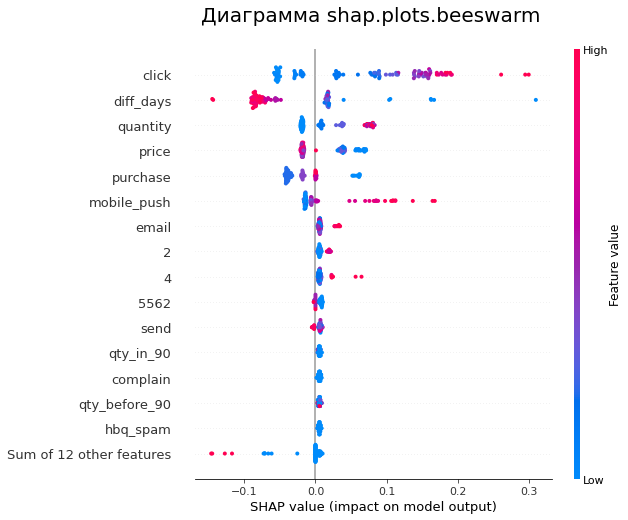

In [131]:
plt.title("Диаграмма shap.plots.beeswarm \n",fontsize=20)
shap.plots.beeswarm(shap_values[:,:,1], max_display=16) 

На примере первых 100 строк из Х можно сделать вывод, что наиболее влияющие признаки это:
- click, сколько раз пользователь кликнул, большое количество кликов склоняет модель к предсказанию новой покупки,
- diff_days, дней с последней продажи, при большом количестве дней новая покупка скорее всего совершена не будет,
- quantity, количество покупок за все время, при большом количество покупок новая скорее всего будет совершена.

На этом этапе были созданы две модели, с точки зрения показателя roc_auc была выбрана лучшая модель - LightGBM, её показатели 0,738 на кросс-валидации и 0,69 на тестовой выборке.

## Общий вывод

Целью задачи было предсказать вероятность покупки в ближайшие 90 дней.   
Исходными данными были три файла, с информацией о покупках, с информацией о рекламных рассылках, а также образец предсказания.  
На этапе предобработки были удалены явные задвоения, категории товара разбиты на отдельные столбцы.  
Было выяснено, что:  
данные предоставлены за период с мая 2022 по февраль 2024 года, как по продажам, так и по рассылке сообщений,   
цены от 1 рубля до 40 тысяч рублей,  
за одну продажу продается в подавляющем большинстве случаев одна штука какого-либо товара,    
большинство действий с точки зрения взаимодействия с пользователем, это отправка и открытие сообщений, непосредственно продаж очень мало на этом фоне,   
с точки зрения канала рассылки бóльшая часть у мобильных уведомлений, меньшая часть у электронной почты,  
количество рассылаемых сообщений в течении двух лет выросло, а продажи – нет.  
К имеющимся данным были добавлены несколько признаков, один из которых, количество дней с последней продажи, оказался достаточно полезным в использованных моделях.  
Были созданы две модели, линейной регрессии и LightGBM.  
Выбор лучшей модели осуществлялся по показателю roc_auc. С этой точки зрения лучшей моделью оказалась LightGBM, её показатели 0,738 на кросс-валидации и 0,69 на тестовой выборке.